# My first random chosen Kaggle dataset

In this JupyterNotebook I compare several classifiers on the Heart Disease UCI data to explore and learn the abilities of machine learning.


Text, text, text....

In [2]:
# Import the packages to load the data and inspect
import numpy as np
import pandas as pd
import math
import warnings
import matplotlib.pyplot as plt
%matplotlib inline


# Some functions give warnings, I turn them off
warnings.filterwarnings("ignore")

# Addtionally we can interface with the kaggle database and download the data directly
# https://www.kaggle.com/ronitf/heart-disease-uci/download

In [3]:
# File to load in is a csv file
heart_data = pd.read_csv("heart.csv", sep = ",");

After loading the data using the pandas package we can inspect the amount of cases and features we have in our dataset

In [4]:
feature_names = tuple(heart_data.columns)

print("The heart data contains {} datapoints, each with {} features".format(heart_data.shape[0], heart_data.shape[1]))
print("These features are: {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}. Using these features we will try to predict if a patient is likely to have a heart disease"
      .format(feature_names[0], feature_names[1], feature_names[2], feature_names[3], feature_names[4], feature_names[5], feature_names[6],
                                                                                       feature_names[7], feature_names[8], feature_names[9], feature_names[10], feature_names[11], feature_names[12]))
print("below the first 10 patients are shown \n")

heart_data.head(n = 10)

The heart data contains 303 datapoints, each with 14 features
These features are: age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal. Using these features we will try to predict if a patient is likely to have a heart disease
below the first 10 patients are shown 



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [5]:
heart_data[heart_data["ca"] == 4]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
92,52,1,2,138,223,0,1,169,0,0.0,2,4,2,1
158,58,1,1,125,220,0,1,144,0,0.4,1,4,3,1
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
251,43,1,0,132,247,1,0,143,1,0.1,1,4,3,0


We seem to have 303 patients, each having 14 features, including: age, sex and cholesterol. The last feature denotes the target, control or not.

An important aspect to consider prior to any analysis using predictive models is investigating wether or not the data is balanced. Unbalanced data can result in certain biasses, which in turn make the resulting model less or completely useless for future use.

Below we plot the distributions of each of the features in the data as a means of visualizing the data.

In [145]:
# Several illustrative plots to inspect the data in more depth
def feature_distribution(data, figsize = (15,15)):
    """
    A function to visualise the distributions of each feature within the given data
    Might need some brushing up (Might need some additional tweaks in the future)

    """
    
    plt.figure(figsize= figsize)
    
    cols = len(data.columns)

    i = 1
    for feature in data.iteritems():
        
        plt.subplot(cols // 2, 2,i)
        xint = range(math.floor(min(feature[1])), math.ceil(max(feature[1]) + 1))
        data[feature[0]].hist(grid = False, bins = len(data[feature[0]].unique()), rwidth = 0.9)
        if len(xint) < 10:
            plt.xticks(xint)
        plt.xlabel(feature[0])
        i += 1
    
    plt.tight_layout()
    plt.show()
    
    
def plot_feature_to_feature(data, figsize = (30,30), lw = 2, colors = ["red", "blue"], alpha = 0.8):
    
    """
    plot features to each other to see if potential relations exist prior to preprocessing
    
    """
    
    plt.figure(figsize= figsize)
    cols = len(data.columns)
    
    i = 1
    for feature_1 in data.columns:
        for feature_2 in data.columns:
            
            plt.subplot(cols, cols, i)
            plt.scatter(data[feature_1], data[feature_2], alpha = alpha, lw=lw)
            plt.xlabel(feature_1)
            plt.ylabel(feature_2)
            i += 1
    
    
    plt.tight_layout()
    plt.show()
    
    
def plot_ROC(fpr, tpr, thresholds, title):
    
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], transform = ax.transAxes, ls = "--", c = ".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title(title)
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    
    
def run_model(model, X_tr, y_tr, X_val, y_val):
    
    
    """
    Run a given model and print out score (train, text), sensitivity, specificity and AUC
    """
    
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    conf_matrix = confusion_matrix(y_pred, y_val)
    sensitivity = round(conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0]), 2)
    specificity = round(conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]), 2)
    fpr, tpr, thresholds = roc_curve(y_pred, y_val)
    
    print("Prediction score on training data: {}". format(round(model.score(X_tr, y_tr) * 100, 2)))
    print("Prediction score on test data: {}". format(round(model.score(X_val, y_val) * 100, 2)))
    print("Confusion matrix:\n")
    print(conf_matrix)
    print("This model has a sensitivity of {} and a specificity of {}".format(sensitivity, specificity))
    #plot_ROC(fpr, tpr, thresholds, "ROC-curve linear SVM")
    print("The Area Under the Curve (AUC) is {}".format(round(auc(fpr, tpr) * 100, 2)))
    print("\n")

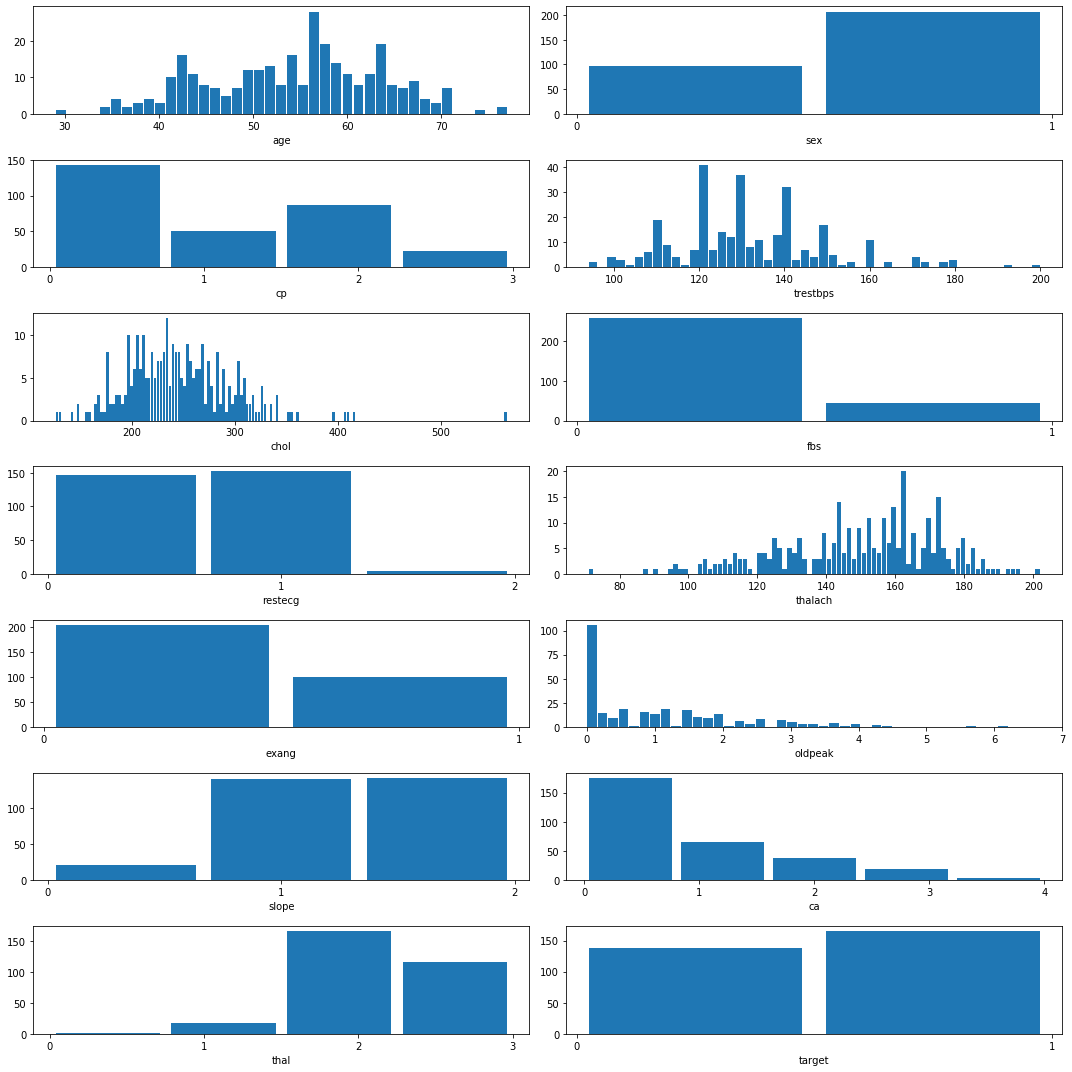

In [7]:
feature_distribution(heart_data)

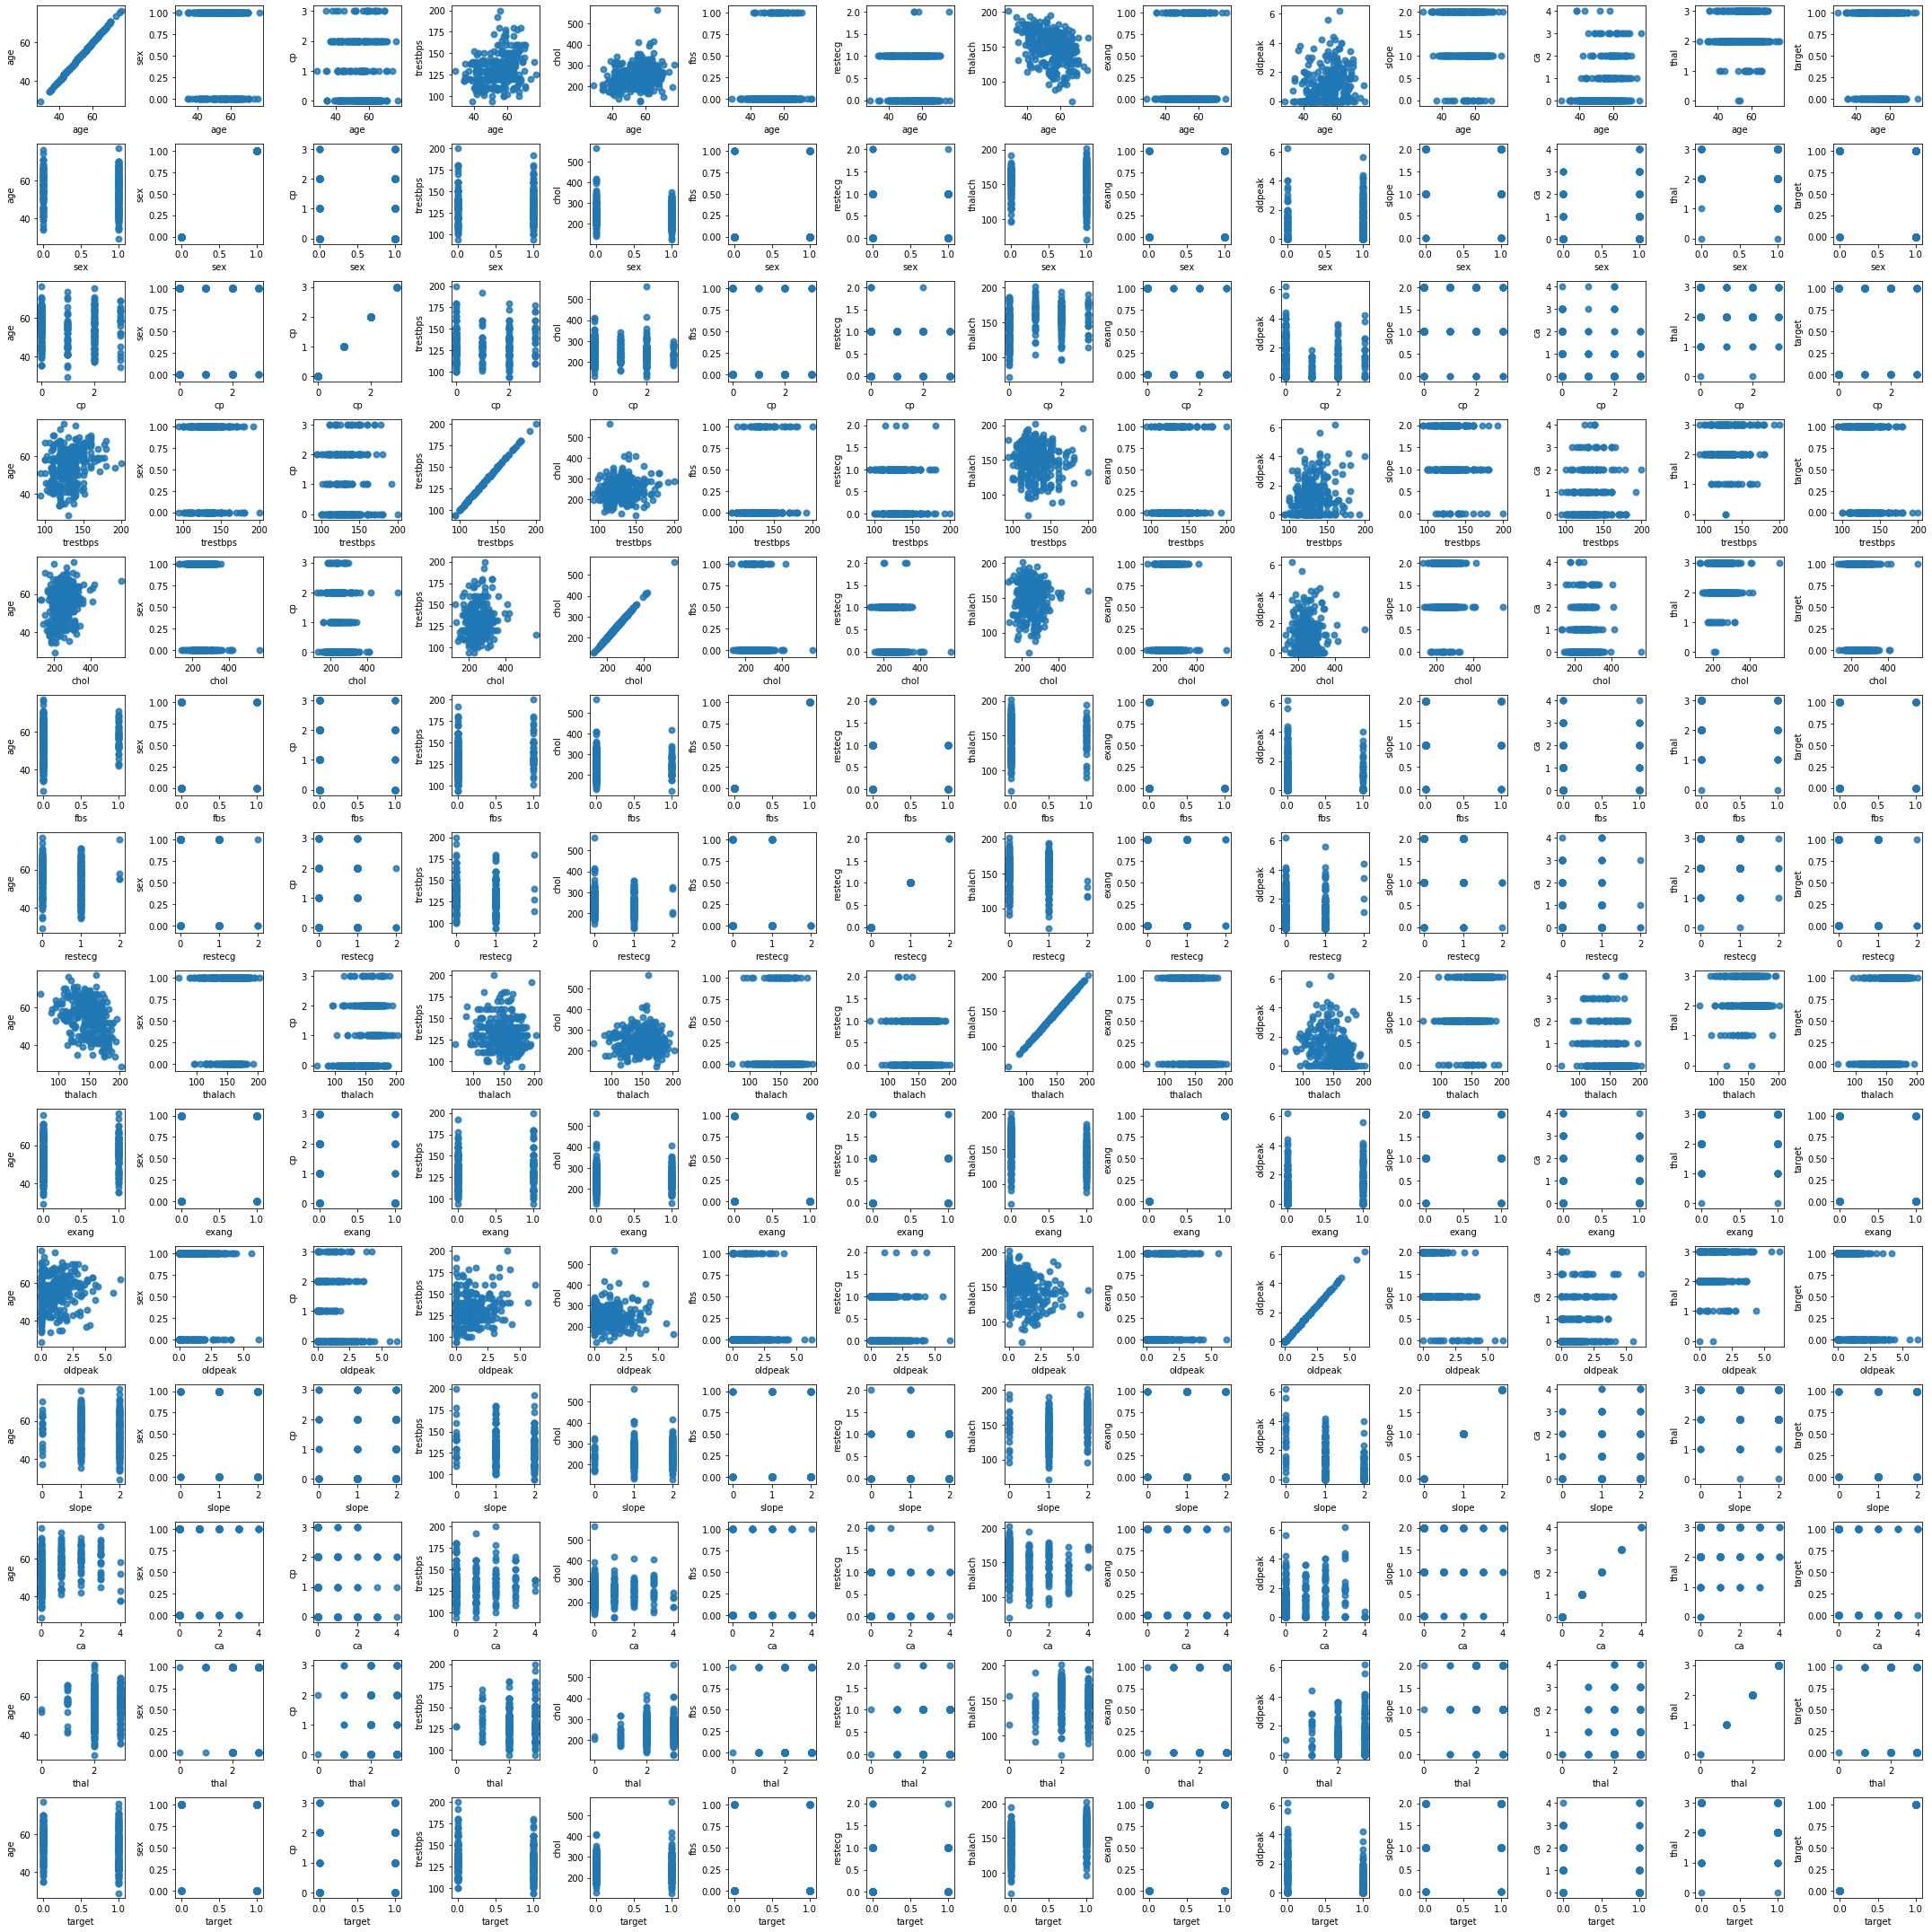

In [8]:
plot_feature_to_feature(heart_data)

As can be seen from the data, the features do not show any particular distributions accros the samples. There is also some slight inbalance in the target classes with the disease being more prominent than the amount of healthy controls. This might be corrected for downstream.

In [9]:
# Split data in features in and classes.
data_features = heart_data.iloc[:, :-1] 
data_classes = heart_data["target"]
classes = data_classes.unique()

# Data Preprocessing

As predictive models, like Support Vector machines (SVMs) or Artificial/Convolution Neural Netorks (ANN/CNN), require the features often preprocessed. This preprocessing can be performed in different manners and differs depending if the feature in particular is continuous or discrete in nature, nominal or ordinal categorical.

Below we will go through each of the heart data features and determine the appropriate way to preprocess each of them individually. Afterwards we will compare the impact of this preprocessing using several well-known predictive models for binary classification.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_curve, classification_report, confusion_matrix

## Age

The first feature in our data is age. This feature is discrete in nature as it only contains integers, yet it cannot be considered as a numeric feature. Why? Well numerical data is typically represented by continuous floats. Integers on the other hand, are typically used to represent categorical data. So is age a categorical feature then?

Technically age is a continuous variable (and also a ratio, as 0 is a meaningfull variable, you cannot be negative years old). A person can be 26 years and 3 months old, which equates to 26.25 old. The same person 6 months later will be 26.75 years old. We could in our case change the discrete values into continuous values if we had the date of birth and date of data collection for each person. This is not the case however, thus we cannot do that. Furthermore some ages in the spectrum are missing, meaning that some groups are not represented in the training data. As such we might try to perform some kind of binning procedure, yet binning causes us to lose some information in the progress. In this instance age will be considered as a continuous variable

for more info see: https://www.theanalysisfactor.com/level-of-measurement-not-obvious/


## ## Sex, Chestpain, Fasting blood sugar, restecg, exercise induced angina, slope, Major vessels coloured by fluoroscopy, thalasemia

The following features are, in contrast to age, catergorical in nature and will thus undergo a different kind of preprocessing than the 4 remaining features (Cholesterol, trestbps, thalach and oldpeak. However, these features can further be split in 2 distinct groups: nominal categories or ordinal categories. Nominal categorical features are catergorical features were one category cannot be ordered as being higher in hierarchy. Ordinal catergoricals on the other hand can be order in a logical manner.

### Sex

This feature for example is a nominal catergorical, as a male cannot be more or less than a female, this true the other way around as well. Furthermore the catergorical is binary in nature with a value of 0 being a female and 1 a male. We could split this catergorical in 2 separate features using the pd.get_dummies function, yet this would be pointless due to this binary nature.

literature about sex and heart disease

### Chestpain

literature about Chestpain and heart disease

### Fasting blood sugar

literature about Fasting blood sugar and heart disease

### rest electro cardiogram

literature about rest-ECG and heart disease

### Exercise induced angina

literature about Exercise induced angina and heart disease

### Slope

literature about Slope and heart disease

### Major vessels visible during flouroscopy (renamed Coronary arteries)

The coronary arteries feature, denotes the amount of arteries that were visible when performing fluoroscopy imaging on the heart. Although noted in the summary page as ranging from 0-3, it actually ranges from 0-4 (this can be observed when pd.get_dummies is used on this feature, which create 5 dummy variables). ALthough not my field of knowledge, I assume this feature refers to the 4 main coronary arteries on the heart. These 4 are the right coronary artery, the left main coronary artery, the left anterior descending artery and the left circumflex artery. (add figure and reference). 

This categorical is ordinal in nature because the amount of Coronary arteries aboserved in one patient is higher/lower/equal when comparing to with other patients.

for more information on this topic see:
    
   - [Coronary artery angiography(youtube)](https://www.youtube.com/watch?v=GhNT2G1fkJg)
    
   - additional literature about Coronary arteries and heart disease

### Thalasemia

## Cholesterol, trestbps, thalach and oldpeak

These variables although integers (possibly rounded during/after testing) are known to be continuous in nature and will be scaled accordingly. For this scaling the sklearn StandardScaler will be used. Alternatively we could perform a log- or power-transform on these features as well, making the data more normally distributed (Gaussian).

### Cholesterol

literature about Cholesterol and heart disease

### Test rest heart beat

literature about rest heart beat and heart disease

### Thalach

literature about Thalach and heart disease

### oldpeak

literature about oldpeak and heart disease

https://www.kaggle.com/learn/intermediate-machine-learning
https://chrischow.github.io/dataandstuff/2018-09-01-preventing-contamination/
https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split

In [115]:
def train_test_contamination_prevention(data_features, data_classes):

    """
    Function could be more generilzed for other projects, now it is completely hard coded for this instance of data
    """
    
    # First we will create several dummy variables for the categorical features like Chestpain, Major vessels and Thalasemia
    Chestpain = pd.get_dummies(data_features["cp"], prefix = "Chestpain_type", prefix_sep = ': ' , )
    Major_vessels = pd.get_dummies(data_features["ca"], prefix = "#Coronary arteries", prefix_sep = ': ')
    Thalasemia = pd.get_dummies(data_features["thal"], prefix = "Thalasemia", prefix_sep = ": ")
    Slope = pd.get_dummies(data_features["slope"], prefix = "Slope", prefix_sep = ": ")
    
    data_features_dummies = pd.concat([data_features, Chestpain, Major_vessels, Thalasemia, Slope], axis = 1)
    data_features_dummies = data_features_dummies.drop(["cp", "ca", "thal", "slope"], axis = 1)
    
    
    X_train, X_test, y_train, y_test = train_test_split(data_features, data_classes, random_state = 0, test_size = 0.2)
    X_train_dummies, X_test_dummies, y_train, y_test = train_test_split(data_features_dummies, data_classes, random_state = 0, test_size = 0.2)
    
    
    # Default scaling of all the features (this is likely not the best idea, yet below we will observe that this already results in an increase in accuracy)
    scaler = StandardScaler()
    
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns.tolist())
    X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns.tolist())

    # individual feature scaling
    numeric_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
    ct = ColumnTransformer([("numerical", StandardScaler(), numeric_features)], remainder="passthrough")

    X_train_preproc = pd.DataFrame(ct.fit_transform(X_train_dummies), columns = X_train_dummies.columns.tolist())
    X_test_preproc = pd.DataFrame(ct.fit_transform(X_test_dummies), columns = X_test_dummies.columns.tolist())
    
    # Rename each of the features to a more explanatory one

    X_train_preproc.columns = ['Age', 'Sex', 'Rest_blood_pressure', 'Cholesterol_levels(mg/dl)', 'Fasting_blood_sugar_level_>_120_mmHg', 'Restecg', 'Thalach', 'Exercise_angina', 
                                 'Oldpeak', 'Chestpain: 0', 'Chestpain: 1', 'Chestpain: 2', 'Chestpain: 3', 'Coronary arteries: 0', 'Coronary arteries: 1', 'Coronary arteries: 2', 
                                 'Coronary arteries: 3','Coronary arteries: 4', 'Thalasemia: 0', 'Thalasemia: 1', 'Thalasemia: 2', 'Thalasemia: 3', 'Slope: 0', 'Slope: 1', 'Slope: 2']

    X_test_preproc.columns = ['Age', 'Sex', 'Rest_blood_pressure', 'Cholesterol_levels(mg/dl)', 'Fasting_blood_sugar_level_>_120_mmHg', 'Restecg', 'Thalach', 'Exercise_angina', 
                                 'Oldpeak', 'Chestpain: 0', 'Chestpain: 1', 'Chestpain: 2', 'Chestpain: 3', 'Coronary arteries: 0', 'Coronary arteries: 1', 'Coronary arteries: 2', 
                                 'Coronary arteries: 3','Coronary arteries: 4', 'Thalasemia: 0', 'Thalasemia: 1', 'Thalasemia: 2', 'Thalasemia: 3', 'Slope: 0', 'Slope: 1', 'Slope: 2']
    
    
    X_train_scaled.columns = ['Age', 'Sex', 'Rest_blood_pressure', 'Cholesterol_levels(mg/dl)', 'Fasting_blood_sugar_level_>_120_mmHg', 'Restecg', 'Thalach', 'Exercise_angina', 
                                 'Oldpeak','Slope', 'Chestpain','Coronary arteries', 'Thalasemia']

    X_test_scaled.columns = ['Age', 'Sex', 'Rest_blood_pressure', 'Cholesterol_levels(mg/dl)', 'Fasting_blood_sugar_level_>_120_mmHg', 'Restecg', 'Thalach', 'Exercise_angina', 
                                 'Oldpeak','Slope', 'Chestpain','Coronary arteries', 'Thalasemia']

    X_train.columns = ['Age', 'Sex', 'Rest_blood_pressure', 'Cholesterol_levels(mg/dl)', 'Fasting_blood_sugar_level_>_120_mmHg', 'Restecg', 'Thalach', 'Exercise_angina', 
                                 'Oldpeak','Slope', 'Chestpain','Coronary arteries', 'Thalasemia']
    
    X_test.columns = ['Age', 'Sex', 'Rest_blood_pressure', 'Cholesterol_levels(mg/dl)', 'Fasting_blood_sugar_level_>_120_mmHg', 'Restecg', 'Thalach', 'Exercise_angina', 
                                 'Oldpeak','Slope', 'Chestpain','Coronary arteries', 'Thalasemia']
    
    
    return X_train, X_test, X_train_scaled, X_test_scaled, X_train_preproc, X_test_preproc, y_train, y_test

In [116]:
X_train, X_test, X_train_scaled, X_test_scaled, X_train_preproc, X_test_preproc, y_train, y_test = train_test_contamination_prevention(data_features, data_classes)

# Low dimensional plotting using dimensionality reduction approaches 

To get some idea/overview of how the data-points are organised we can transfrorm the data using either t-SNE (t-distributed Stochastic Neighbour Embedding) or PCA (Principal Component Analysis). Using the transfromed data ze can then plot these 13 dimensional data-points on a lower dimension and see if some clustering already occurs prioir to using predictive models like SVMs or Decision trees

In [95]:
# t-SNE and PCA data transformation
from sklearn.manifold import TSNE as tSNE
from sklearn.decomposition import PCA

The choice of whether to use t-SNE over PCA can be a bit arbitrary, yet if the amount of features is excessively high, sources advise to first use PCA and reduce it to 50 features(sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html?highlight=t%20sne#sklearn.manifold.TSNE   

## PCA

literature about PCA

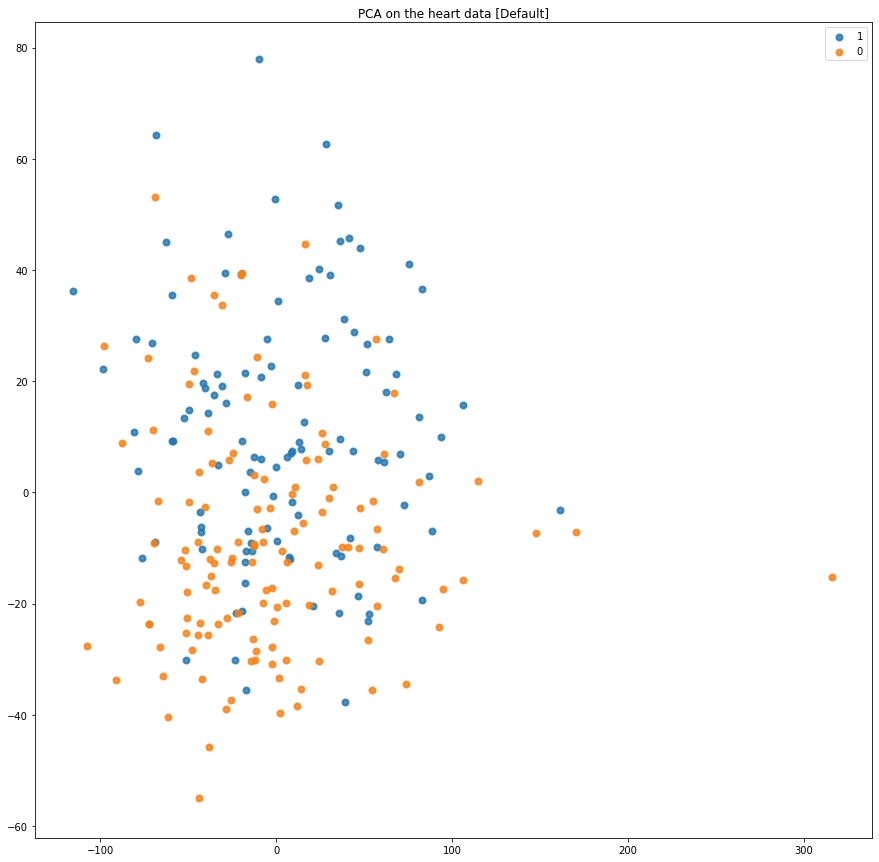

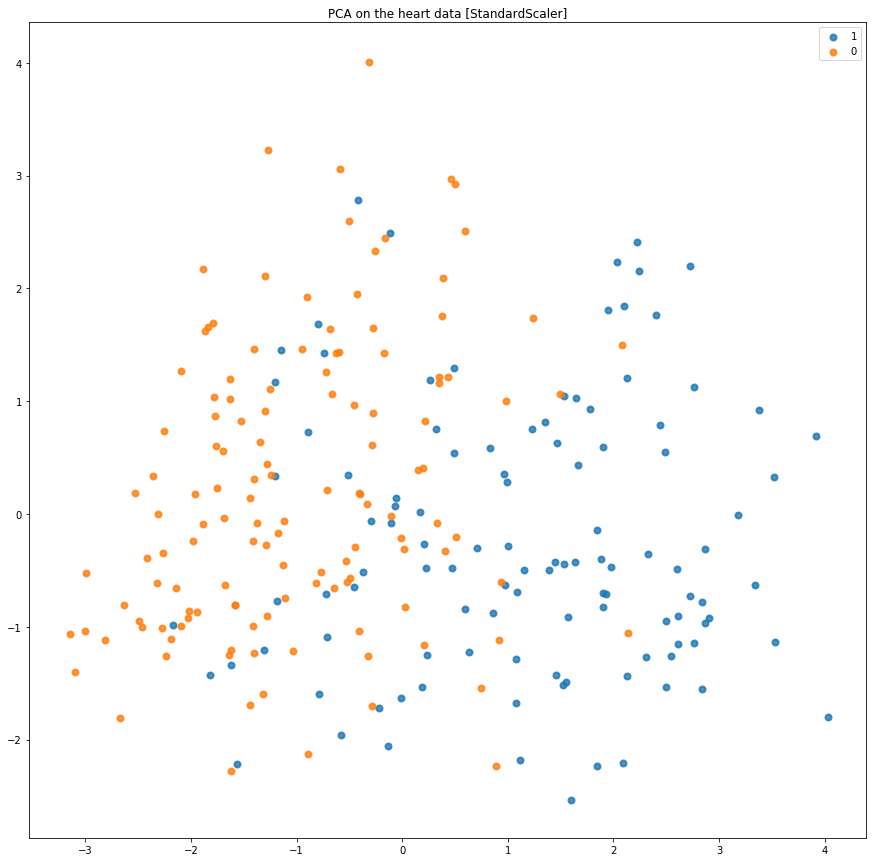

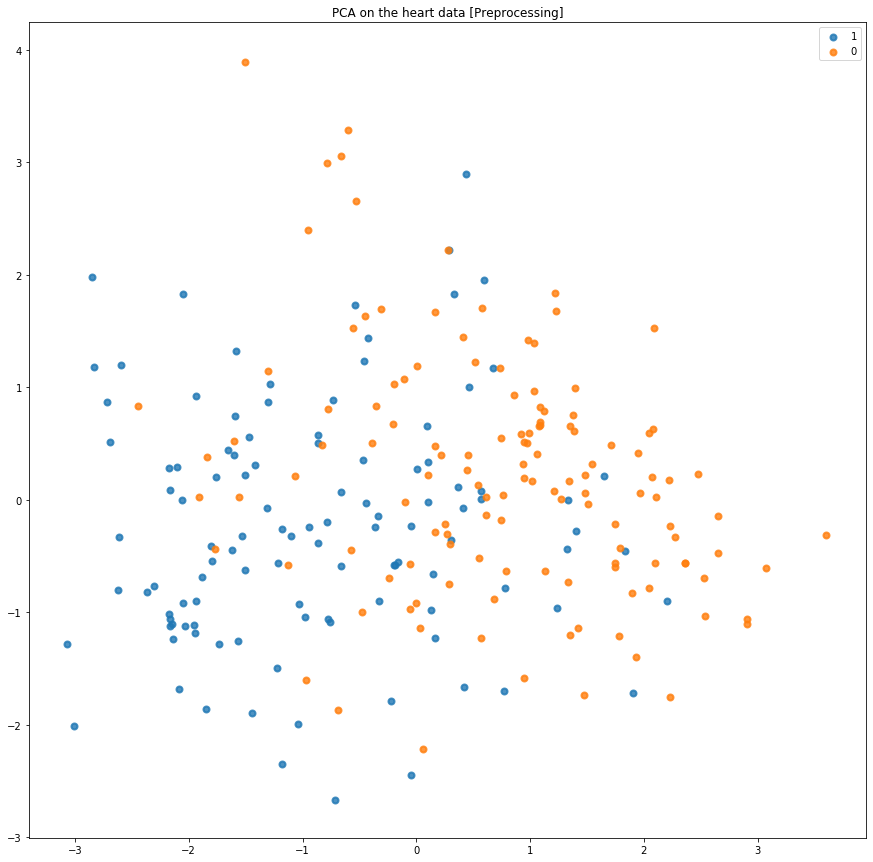

In [96]:
for data_set, preproc in zip([[X_train, y_train], [X_train_scaled, y_train], [X_train_preproc, y_train]], ["Default", "StandardScaler",  "Preprocessing"]):

    
    PCA_model = PCA(n_components = None, random_state=0).fit_transform(data_set[0])

    # Scatter plot of the data based on the first 2 principal components
    plt.figure(figsize= (15,15))
    colors = ['r', 'c']
    lw = 2

    for color, i, label in zip(colors, [0, 1], classes):
        plt.scatter(PCA_model[y_train == i, 0], PCA_model[y_train == i, 1], alpha = 0.8, lw=lw, label = label)
        plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
        plt.title("PCA on the heart data [{}]".format(preproc))

Plotting the data in low dimension using PCA reveals that the data is not seperated based on the 2 first PCs, regardless of the preproccessing. Below we use another method to visualise the data grouping between the data points. t-SNE, or t-distributed Stochastic Neighbour Embedding. Note that both these method are only means of reducing the dimensiontality for plotting, and are not predictive tools. They both perform a data transformation on the original data, which can be used further downstream if desired.

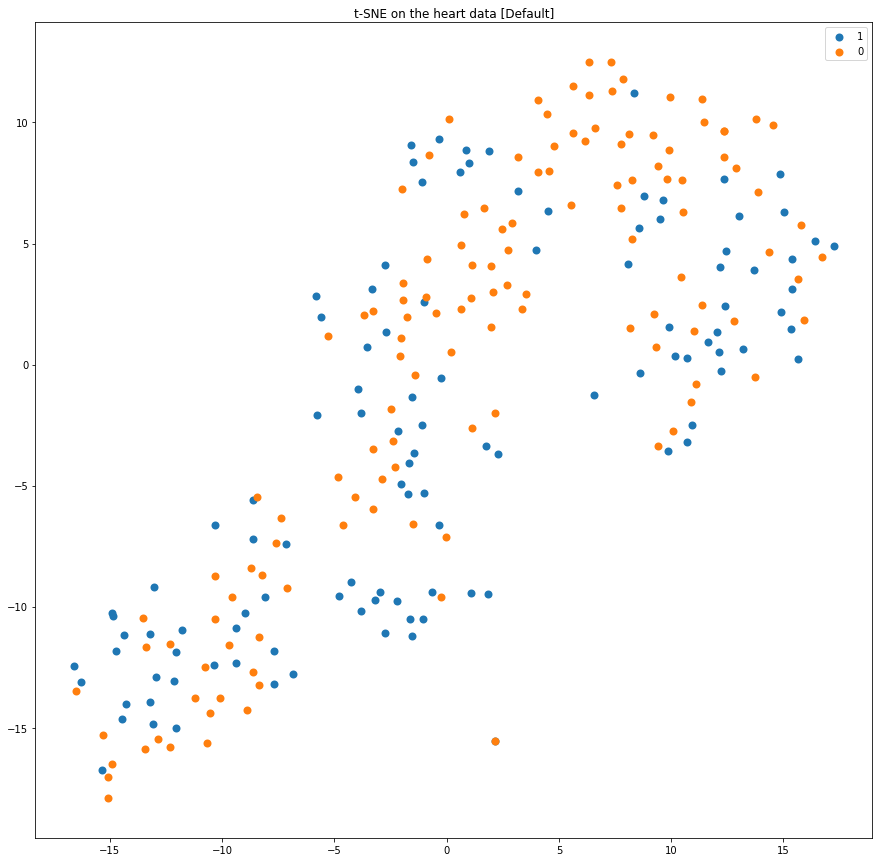

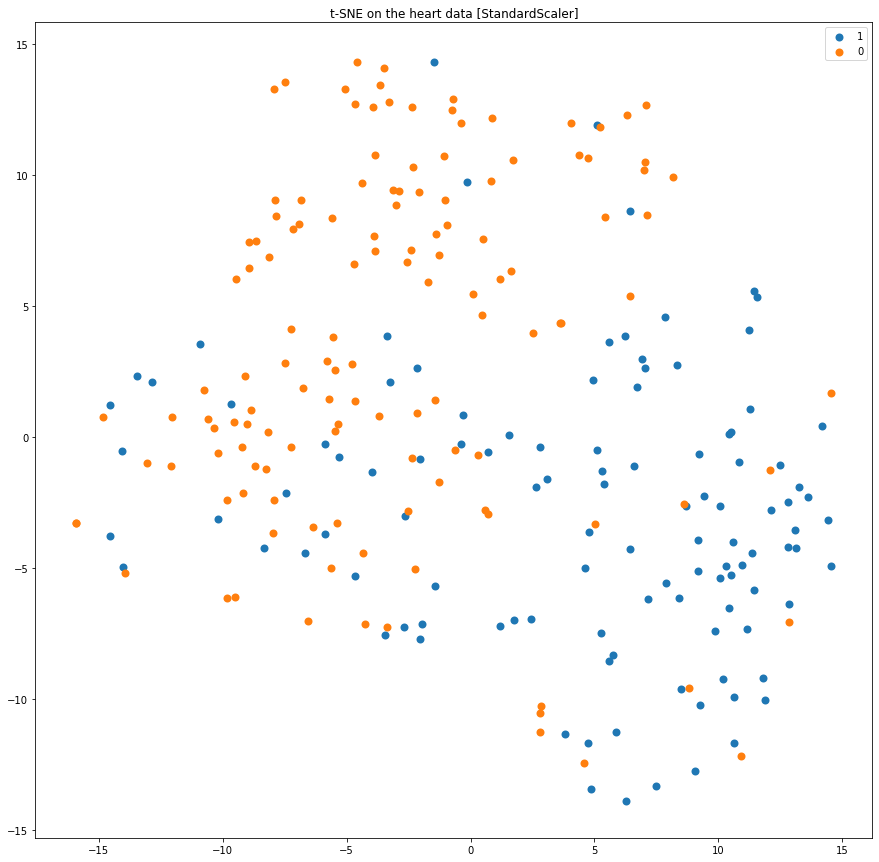

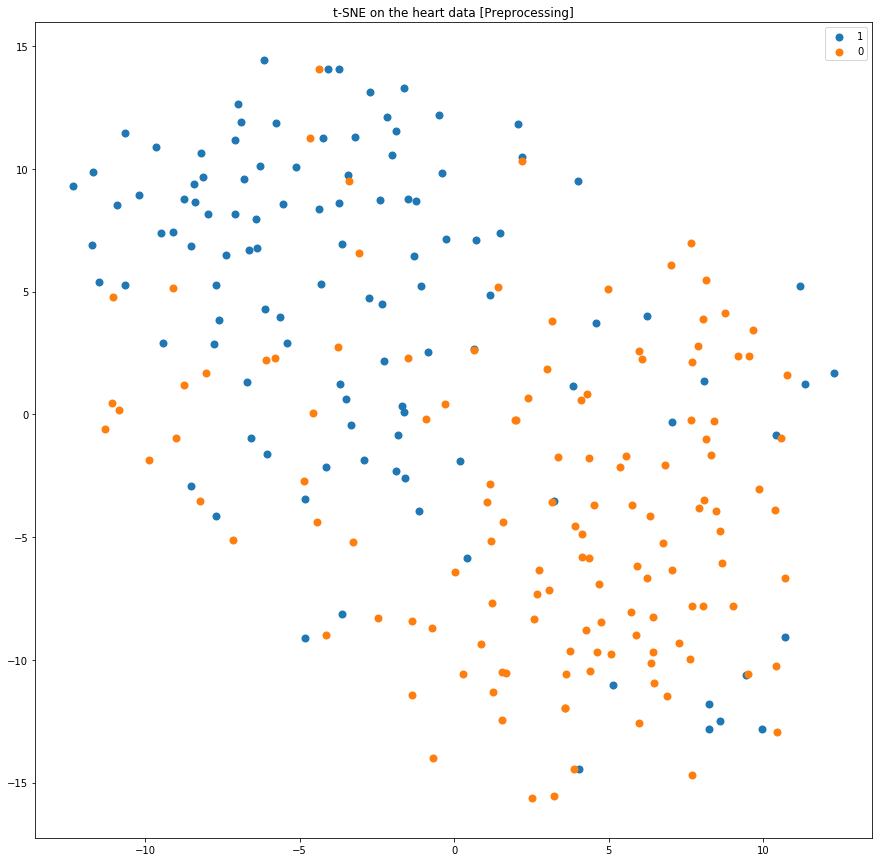

In [97]:
for data_set, preproc in zip([[X_train, y_train], [X_train_scaled, y_train], [X_train_preproc, y_train]], ["Default", "StandardScaler",  "Preprocessing"]):

    # Data transformation using t-SNE
    tSNE_model = tSNE(random_state=0).fit_transform(data_set[0])

    # Plotting the t-SNE transformation
    plt.figure(figsize=(15, 15))
    colors = ['r', 'c']
    lw = 2

    for color, i, label in zip(colors, [0, 1], classes):
        plt.scatter(tSNE_model[data_set[1] == i, 0], tSNE_model[data_set[1] == i, 1], lw = lw, label = label)
        plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
        plt.title("t-SNE on the heart data [{}]".format(preproc))

For the default data features t-SNE is also not able to separate both groups from each other on their 2 first prinicipal components. However, both the scaled and preprocessed data_features show a much better separation on the t-SNE plots. This might indicate that there are indeed several features that are very import in determining heart disease.

# Predictive models

Below several approaches are used on the training and test data groups with the aim to selcet one/multiple methods as viable options to predict potential heart problems. Afterwards both a PermutationImportance and model feature impact analysis (using SHAP) will be performed on each adequate model. The purpose of testing several predictive models is to find out if one is better than the other, as well as to find out if multiple models converge on the same important features. While this last one is likely to be the case, it serves as more way to justify that some features might be more important than other in determining the state of disease. 

## Support Vector Machines

Support Vector Machines (SVMs) is a modelling approach were the goal is to create a hyperplane that is able to separate one class of data-points from another class of data points in a high dimensional space. The hyperplane has by definition a dimension of n-1, with n being the dimension in whcih the data is projected. More information to add. 

One trick the SVM approach it able to perform in known as the kernel trick. Thei trick/workaround allows the model to transform the data-points to a higher dimension than initially given. This transformation would require a lot of computation, yet the kernel trick allows for a relatively fast transformation and skipping the long time that would be required for calculation. The function that perfroms this transformation is known as the kernel-function and several options are available for use. Below a linear, sigmoid and (the default) radial basis function are used on the data. The choice of which kernel to use can impact the resulting predictive calculations of the model, thus making it important to test out several potential options.

The models are all used in their default settings unless specified otherwise

In [16]:
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.svm import SVC

When using SVMs (a method that utilises the kernel trick) you have the choice of several kernel functions. Among these are the linear kernel, the radial basis function (rbf), and polynomial kernels (degree of 2+). Depending on the problem the one kernel wil function better than another one. The use of polynomial kernels of high degrees might be costly over time. Additionally SVMs are not invariant to scaling, as such it is highly recommended to scale the data beforehand. Below we will also compare it scaling really benefits the predicitve efficiency of the 3 SVM approaches when the data is scaled.

In [80]:
# Different approaches to use support vector machines

C = 1.0
SVM_model_linear = SVC(kernel = "linear", C =C)
SVM_model_rbf = SVC(kernel ="rbf", gamma = "scale", C =C)
SVM_model_sigmoid = SVC(kernel = "sigmoid", gamma = 'scale', C = C)
SVM_model_poly = SVC(kernel = "poly", gamma = 'scale', C = C)

In [134]:
# Split the data in train-test

for data_set, preproc in zip([[X_train, y_train, X_test, y_test], [X_train_scaled, y_train, X_test_scaled, y_test], [X_train_preproc, y_train, X_test_preproc, y_test]], ["Default", "StandardScaler",  "Preprocessing"]):
    
    print(preproc + "\n")
    
    for model in [SVM_model_linear, SVM_model_rbf, SVM_model_sigmoid, SVM_model_poly]:
        
        run_model(model, data_set[0], data_set[1], data_set[2], data_set[3])

Default

Prediction score on training data: 84.71
Prediction score on test data: 81.97
Confusion matrix:

[[20  4]
 [ 7 30]]
This model has a sensitivity of 0.81 and a specificity of 0.83
The Area Under the Curve (AUC) is 82.21


Prediction score on training data: 66.53
Prediction score on test data: 68.85
Confusion matrix:

[[13  5]
 [14 29]]
This model has a sensitivity of 0.67 and a specificity of 0.72
The Area Under the Curve (AUC) is 69.83


Prediction score on training data: 53.72
Prediction score on test data: 55.74
Confusion matrix:

[[ 0  0]
 [27 34]]
This model has a sensitivity of 0.56 and a specificity of nan
The Area Under the Curve (AUC) is nan


Prediction score on training data: 67.77
Prediction score on test data: 72.13
Confusion matrix:

[[15  5]
 [12 29]]
This model has a sensitivity of 0.71 and a specificity of 0.75
The Area Under the Curve (AUC) is 72.87


StandardScaler

Prediction score on training data: 84.3
Prediction score on test data: 81.97
Confusion matrix:

As we can see when no scaling or preprocessing is used on the data both the sigmoid and rbf kernels score relatively low, especially the rbf kernel. However after either scaling the numeric data or total preprocessing the scores, sensitivity, specificity and AUC scores increase for the sigmoid and rbf kernels, reaching somewhere between 80-88% on each of these respective scoring metrics. This makes SVM for either of the 4 kernels used an adequate candidate to predict potential heart disease. As they present practically identical scores when data (train and test) are preprocessed completely (Dummies and StandardScaling) all 4 approaches will be included in end when inspecting feature importance.

## RidgeClassifier.

The RidgeClassifier is a variant of the RidgeRegression approach that can be used for classification instead of regression. In this case our target values 0 and 1, will first be converted into values of -1 and 1 (similar to how the SVM model above works) and will then perform a regression on the resulting data points. Unlike the SVM used above the RidgeClassifier used a Least-Square Loss function with an L2-regularization. SVMs as mentioned above, use the hinge loss as their loss function, yet also include the L2-regularization in their minimization steps. As such the RidgeClassifier is sometime called the Least Squares SVM as well.

In [19]:
from sklearn.linear_model import RidgeClassifier

In [136]:

for data_set, preproc in zip([[X_train, y_train, X_test, y_test], [X_train_scaled, y_train, X_test_scaled, y_test], [X_train_preproc, y_train, X_test_preproc, y_test]], ["Default", "StandardScaler",  "Preprocessing"]):
    
    print(preproc + "\n")
    
    model = RidgeClassifier(random_state=0)
    
    run_model(model, data_set[0], data_set[1], data_set[2], data_set[3])

Default

Prediction score on training data: 83.47
Prediction score on test data: 83.61
Confusion matrix:

[[20  3]
 [ 7 31]]
This model has a sensitivity of 0.82 and a specificity of 0.87
The Area Under the Curve (AUC) is 84.27


StandardScaler

Prediction score on training data: 83.47
Prediction score on test data: 83.61
Confusion matrix:

[[20  3]
 [ 7 31]]
This model has a sensitivity of 0.82 and a specificity of 0.87
The Area Under the Curve (AUC) is 84.27


Preprocessing

Prediction score on training data: 87.6
Prediction score on test data: 86.89
Confusion matrix:

[[23  4]
 [ 4 30]]
This model has a sensitivity of 0.88 and a specificity of 0.85
The Area Under the Curve (AUC) is 86.71




As we can observe for both the unprocessed and StandardScaled data the model scores identical (might be by chance) on all aspects. When adding dummy variables into the mix however the scores increases by 3%. This increase in total score is associated by an increase in sensitivity and a small decrease in specificity. As the score seem to fluctuate between 82-87% this models is also deemed as adequate for downstream feature analysis.

## Logistic regression classification

Another approach we can take to perform the classification is to use Logistic regression

In [21]:
from sklearn.linear_model import LogisticRegression

In [138]:
for data_set, preproc in zip([[X_train, y_train, X_test, y_test], [X_train_scaled, y_train, X_test_scaled, y_test], [X_train_preproc, y_train, X_test_preproc, y_test]], ["Default", "StandardScaler",  "Preprocessing"]):
    
    print(preproc + "\n")
    
    model = LogisticRegression(random_state=0)
    
    run_model(model, data_set[0], data_set[1], data_set[2], data_set[3])

Default

Prediction score on training data: 85.12
Prediction score on test data: 85.25
Confusion matrix:

[[22  4]
 [ 5 30]]
This model has a sensitivity of 0.86 and a specificity of 0.85
The Area Under the Curve (AUC) is 85.16


StandardScaler

Prediction score on training data: 84.3
Prediction score on test data: 85.25
Confusion matrix:

[[21  3]
 [ 6 31]]
This model has a sensitivity of 0.84 and a specificity of 0.88
The Area Under the Curve (AUC) is 85.64


Preprocessing

Prediction score on training data: 85.95
Prediction score on test data: 88.52
Confusion matrix:

[[23  3]
 [ 4 31]]
This model has a sensitivity of 0.89 and a specificity of 0.88
The Area Under the Curve (AUC) is 88.52




Similar to the RidgeClassifier the LogisticRegression scores very well on all 3 instances of the input data, with the preprocessing approach score almost 90% on the unseen test data. Because the scores are even higher than the previous model approaches this model is also included below. Tge hight score here does however, not mean the that the model will perform very well in a real setting. 

## Naieve bayes Classifier

There are numerous was the naieve Bayes classifier can be used. One such way is the type of distribution the feature are assumed to have: Gaussian, Multinomial, Bernouilli,... . Below we will use the Gaussian naieve Bayes classifier on both the scaled and unscaled data Note, as some of our features are continueous in nature the Bernouilli Naieve Bayes cannot be used.

In [23]:
from sklearn.naive_bayes import GaussianNB

In [139]:
for data_set, preproc in zip([[X_train, y_train, X_test, y_test], [X_train_scaled, y_train, X_test_scaled, y_test], [X_train_preproc, y_train, X_test_preproc, y_test]], ["Default", "StandardScaler",  "Preprocessing"]):
    
    print(preproc + "\n")
    
    model = GaussianNB()
    
    run_model(model, data_set[0], data_set[1], data_set[2], data_set[3])

Default

Prediction score on training data: 83.47
Prediction score on test data: 85.25
Confusion matrix:

[[21  3]
 [ 6 31]]
This model has a sensitivity of 0.84 and a specificity of 0.88
The Area Under the Curve (AUC) is 85.64


StandardScaler

Prediction score on training data: 83.47
Prediction score on test data: 80.33
Confusion matrix:

[[21  6]
 [ 6 28]]
This model has a sensitivity of 0.82 and a specificity of 0.78
The Area Under the Curve (AUC) is 80.07


Preprocessing

Prediction score on training data: 83.88
Prediction score on test data: 85.25
Confusion matrix:

[[22  4]
 [ 5 30]]
This model has a sensitivity of 0.86 and a specificity of 0.85
The Area Under the Curve (AUC) is 85.16




In this case it seems that scaling the numerical features negatively impacts the predictive capabilities of the model. However, the addition of the dummy variables over the scaling  benefits the model in some manner. Although it could also be that not scalng the data and only adding the dummies might improve the prediction even further.

## K-nearest neighbours

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [140]:
for data_set, preproc in zip([[X_train, y_train, X_test, y_test], [X_train_scaled, y_train, X_test_scaled, y_test], [X_train_preproc, y_train, X_test_preproc, y_test]], ["Default", "StandardScaler",  "Preprocessing"]):
    
    print(preproc + "\n")

    for i in range(5, 20):
    
        print("Amount of neighbours: {}".format(i))
    
        model = KNeighborsClassifier(i)
    
        run_model(model, data_set[0], data_set[1], data_set[2], data_set[3])

Default

Amount of neighbours: 5
Prediction score on training data: 78.1
Prediction score on test data: 63.93
Confusion matrix:

[[17 12]
 [10 22]]
This model has a sensitivity of 0.69 and a specificity of 0.59
The Area Under the Curve (AUC) is 63.69


Amount of neighbours: 6
Prediction score on training data: 74.38
Prediction score on test data: 65.57
Confusion matrix:

[[18 12]
 [ 9 22]]
This model has a sensitivity of 0.71 and a specificity of 0.6
The Area Under the Curve (AUC) is 65.48


Amount of neighbours: 7
Prediction score on training data: 72.31
Prediction score on test data: 67.21
Confusion matrix:

[[18 11]
 [ 9 23]]
This model has a sensitivity of 0.72 and a specificity of 0.62
The Area Under the Curve (AUC) is 66.97


Amount of neighbours: 8
Prediction score on training data: 71.9
Prediction score on test data: 68.85
Confusion matrix:

[[19 11]
 [ 8 23]]
This model has a sensitivity of 0.74 and a specificity of 0.63
The Area Under the Curve (AUC) is 68.76


Amount of neig

Going over the many different options it seems that the ideal amount of neighbours does not really affect the end result that much. The largest impact seems to be coming from the preprocessing, as this approach improves the scoring metrics as a whole over all tested amount of neighbouring points with going as high as 90%.

## Decision Trees and RandomForests

In [141]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

In [143]:
for data_set, preproc in zip([[X_train, y_train, X_test, y_test], [X_train_scaled, y_train, X_test_scaled, y_test], [X_train_preproc, y_train, X_test_preproc, y_test]], ["Default", "StandardScaler",  "Preprocessing"]):
    
    print(preproc + "\n")

    model = DecisionTreeClassifier(random_state = 0)
    run_model(model, data_set[0], data_set[1], data_set[2], data_set[3])
    
    model = DecisionTreeClassifier(criterion= "entropy", random_state=0)
    run_model(model, data_set[0], data_set[1], data_set[2], data_set[3])

Default

Prediction score on training data: 100.0
Prediction score on test data: 78.69
Confusion matrix:

[[22  8]
 [ 5 26]]
This model has a sensitivity of 0.84 and a specificity of 0.73
The Area Under the Curve (AUC) is 78.6


Prediction score on training data: 100.0
Prediction score on test data: 80.33
Confusion matrix:

[[22  7]
 [ 5 27]]
This model has a sensitivity of 0.84 and a specificity of 0.76
The Area Under the Curve (AUC) is 80.12


StandardScaler

Prediction score on training data: 100.0
Prediction score on test data: 77.05
Confusion matrix:

[[21  8]
 [ 6 26]]
This model has a sensitivity of 0.81 and a specificity of 0.72
The Area Under the Curve (AUC) is 76.83


Prediction score on training data: 100.0
Prediction score on test data: 80.33
Confusion matrix:

[[21  6]
 [ 6 28]]
This model has a sensitivity of 0.82 and a specificity of 0.78
The Area Under the Curve (AUC) is 80.07


Preprocessing

Prediction score on training data: 100.0
Prediction score on test data: 80.33

In [144]:
for data_set, preproc in zip([[X_train, y_train, X_test, y_test], [X_train_scaled, y_train, X_test_scaled, y_test], [X_train_preproc, y_train, X_test_preproc, y_test]], ["Default", "StandardScaler",  "Preprocessing"]):
    
    print(preproc + "\n")

    model = RandomForestClassifier(random_state = 0)
    run_model(model, data_set[0], data_set[1], data_set[2], data_set[3])
    
    model = RandomForestClassifier(random_state = 0, criterion= "entropy")
    run_model(model, data_set[0], data_set[1], data_set[2], data_set[3])

Default

Prediction score on training data: 100.0
Prediction score on test data: 88.52
Confusion matrix:

[[24  4]
 [ 3 30]]
This model has a sensitivity of 0.91 and a specificity of 0.86
The Area Under the Curve (AUC) is 88.31


Prediction score on training data: 100.0
Prediction score on test data: 83.61
Confusion matrix:

[[22  5]
 [ 5 29]]
This model has a sensitivity of 0.85 and a specificity of 0.81
The Area Under the Curve (AUC) is 83.39


StandardScaler

Prediction score on training data: 100.0
Prediction score on test data: 83.61
Confusion matrix:

[[22  5]
 [ 5 29]]
This model has a sensitivity of 0.85 and a specificity of 0.81
The Area Under the Curve (AUC) is 83.39


Prediction score on training data: 100.0
Prediction score on test data: 81.97
Confusion matrix:

[[21  5]
 [ 6 29]]
This model has a sensitivity of 0.83 and a specificity of 0.81
The Area Under the Curve (AUC) is 81.81


Preprocessing

Prediction score on training data: 100.0
Prediction score on test data: 85.2

# Inspection of each model

As we can observe for most of these approaches the preprocessing has a slight effect on the accuracy of each model. However, with these model we can merely predict if a new patient is likely to suffer from a heart disease or not, yet we do notnot which of the 13 features are most import to obtain said conclusion. As such each of these methods will be investigated further to see if the same features are important across the different models used.

In [105]:
import eli5
import shap

In [106]:
def PermuteImport_and_SHAPPING_of_multiple_models(models, X_tr, y_tr, X_val, y_val):
    
    results = {}
    
    for instance in models:
        
        model = instance[0]
        model_name = instance[1]
        
        results[model_name] = {"weights" : "", "explainer" : "", "shap_values" : ""}
        
        model.fit(X_tr, y_tr)
        explainer = shap.KernelExplainer(model.predict, X_val)
        results[model_name]["explainer"] = explainer
        results[model_name]["shap_values"] = explainer.shap_values(X_val, )
        linear_SVC_perm = eli5.sklearn.PermutationImportance(model, random_state = 0).fit(X_val, y_val)
        results[model_name]["weights"] = eli5.show_weights(linear_SVC_perm, feature_names = X_val.columns.tolist(), top = None)
                
        
    return results
    
    

In [107]:
models = [[SVC(kernel = "linear", random_state = 0), "Linear_SVC"], [SVC(random_state = 0), "RBF_SVC"], [SVC(kernel = "sigmoid", random_state = 0), "sigmoid_SVC"], 
       [RidgeClassifier(random_state = 0), "RidgeClassifier"], [LogisticRegression(random_state = 0), "LogisticRegression"], [GaussianNB(), "Naieve_bayes"],
       [KNeighborsClassifier(n_neighbors=9), "9-KNNClassifier"], [DecisionTreeClassifier(random_state = 0), "DecisionTreeClassifier"], 
        [RandomForestClassifier(random_state=0), "RandomForestClassifier"]]

results = PermuteImport_and_SHAPPING_of_multiple_models(models, X_train_preproc, y_train, X_test_preproc, y_test);

In [113]:
for model in results:
    print("           " + model + "\n")
    display(results[model]["weights"])
    print("\n")

           Linear_SVC



Weight,Feature
0.0131 ± 0.0435,Coronary arteries: 0
0.0098 ± 0.0161,Thalasemia: 3
0.0066 ± 0.0161,Slope: 2
0.0066 ± 0.0161,Thalach
0.0066 ± 0.0262,Thalasemia: 2
0.0066 ± 0.0161,Fasting_blood_sugar_level_>_120_mmHg
0.0033 ± 0.0245,Coronary arteries: 2
0.0033 ± 0.0245,Chestpain: 0
0 ± 0.0000,Thalasemia: 1
0 ± 0.0000,Thalasemia: 0




           RBF_SVC



Weight,Feature
0.0852 ± 0.0636,Fasting_blood_sugar_level_>_120_mmHg
0.0361 ± 0.0435,Thalasemia: 2
0.0328 ± 0.0207,Age
0.0262 ± 0.0334,Sex
0.0230 ± 0.0262,Chestpain: 2
0.0230 ± 0.0533,Oldpeak
0.0197 ± 0.0245,Exercise_angina
0.0197 ± 0.0382,Rest_blood_pressure
0.0164 ± 0.0207,Slope: 2
0.0131 ± 0.0382,Restecg




           sigmoid_SVC



Weight,Feature
0.0328 ± 0.0549,Thalasemia: 2
0.0328 ± 0.0207,Cholesterol_levels(mg/dl)
0.0295 ± 0.0435,Coronary arteries: 0
0.0230 ± 0.0334,Fasting_blood_sugar_level_>_120_mmHg
0.0164 ± 0.0207,Thalasemia: 3
0.0131 ± 0.0131,Chestpain: 2
0.0098 ± 0.0161,Slope: 2
0.0098 ± 0.0161,Slope: 1
0.0098 ± 0.0262,Chestpain: 0
0.0066 ± 0.0161,Rest_blood_pressure




           RidgeClassifier



Weight,Feature
0.0295 ± 0.0482,Thalasemia: 2
0.0295 ± 0.0382,Chestpain: 0
0.0295 ± 0.0601,Coronary arteries: 0
0.0230 ± 0.0334,Coronary arteries: 2
0.0230 ± 0.0675,Restecg
0.0164 ± 0.0000,Thalasemia: 1
0.0131 ± 0.0131,Rest_blood_pressure
0.0131 ± 0.0245,Cholesterol_levels(mg/dl)
0 ± 0.0000,Slope: 2
0.0000 ± 0.0293,Chestpain: 2




           LogisticRegression



Weight,Feature
0.0492 ± 0.0464,Coronary arteries: 0
0.0361 ± 0.0382,Cholesterol_levels(mg/dl)
0.0328 ± 0.0415,Thalasemia: 3
0.0328 ± 0.0293,Chestpain: 0
0.0295 ± 0.0382,Thalasemia: 2
0.0295 ± 0.0700,Restecg
0.0262 ± 0.0161,Rest_blood_pressure
0.0230 ± 0.0533,Oldpeak
0.0197 ± 0.0245,Fasting_blood_sugar_level_>_120_mmHg
0.0164 ± 0.0000,Chestpain: 2




           Naieve_bayes



Weight,Feature
0.0426 ± 0.0161,Thalasemia: 3
0.0361 ± 0.0245,Thalasemia: 2
0.0328 ± 0.0000,Chestpain: 0
0.0262 ± 0.0334,Chestpain: 2
0.0230 ± 0.0161,Slope: 1
0.0197 ± 0.0482,Coronary arteries: 2
0.0197 ± 0.0245,Cholesterol_levels(mg/dl)
0.0131 ± 0.0435,Restecg
0.0131 ± 0.0245,Chestpain: 1
0.0131 ± 0.0131,Slope: 2




           9-KNNClassifier



Weight,Feature
0.0721 ± 0.0642,Fasting_blood_sugar_level_>_120_mmHg
0.0721 ± 0.0334,Age
0.0623 ± 0.0382,Sex
0.0525 ± 0.0245,Rest_blood_pressure
0.0361 ± 0.0245,Restecg
0.0361 ± 0.0382,Exercise_angina
0.0328 ± 0.0207,Thalasemia: 2
0.0295 ± 0.0131,Coronary arteries: 1
0.0262 ± 0.0334,Thalasemia: 3
0.0230 ± 0.0445,Cholesterol_levels(mg/dl)




           DecisionTreeClassifier



Weight,Feature
0.1279 ± 0.0482,Thalasemia: 2
0.0787 ± 0.0245,Fasting_blood_sugar_level_>_120_mmHg
0.0492 ± 0.0464,Coronary arteries: 0
0.0328 ± 0.0359,Chestpain: 0
0.0033 ± 0.0435,Age
0.0033 ± 0.0525,Rest_blood_pressure
0 ± 0.0000,Chestpain: 2
0.0000 ± 0.0207,Restecg
0 ± 0.0000,Thalach
0 ± 0.0000,Exercise_angina




           RandomForestClassifier



Weight,Feature
0.0361 ± 0.0564,Coronary arteries: 0
0.0197 ± 0.0245,Fasting_blood_sugar_level_>_120_mmHg
0.0131 ± 0.0482,Chestpain: 0
0.0131 ± 0.0245,Chestpain: 3
0.0131 ± 0.0131,Rest_blood_pressure
0.0131 ± 0.0131,Age
0.0098 ± 0.0445,Thalasemia: 2
0.0098 ± 0.0161,Exercise_angina
0.0098 ± 0.0262,Sex
0.0066 ± 0.0161,Chestpain: 1


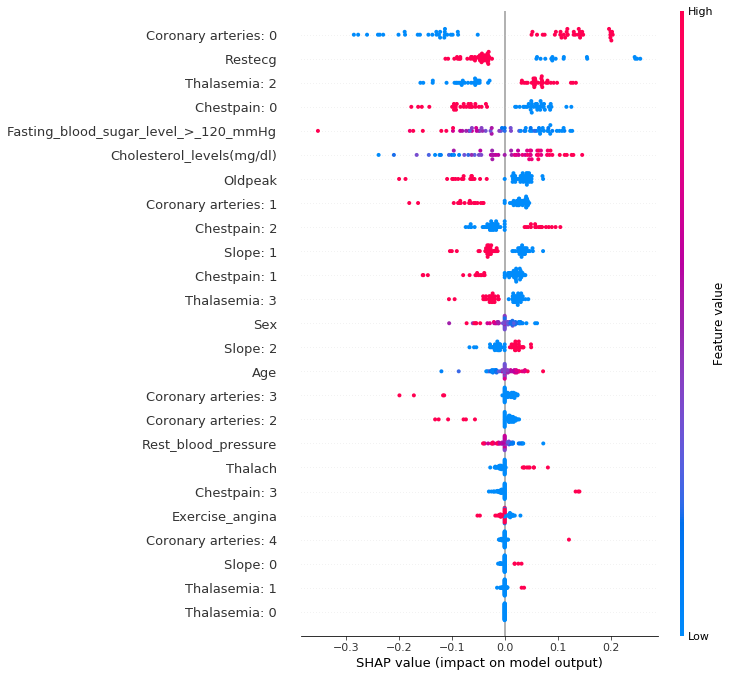

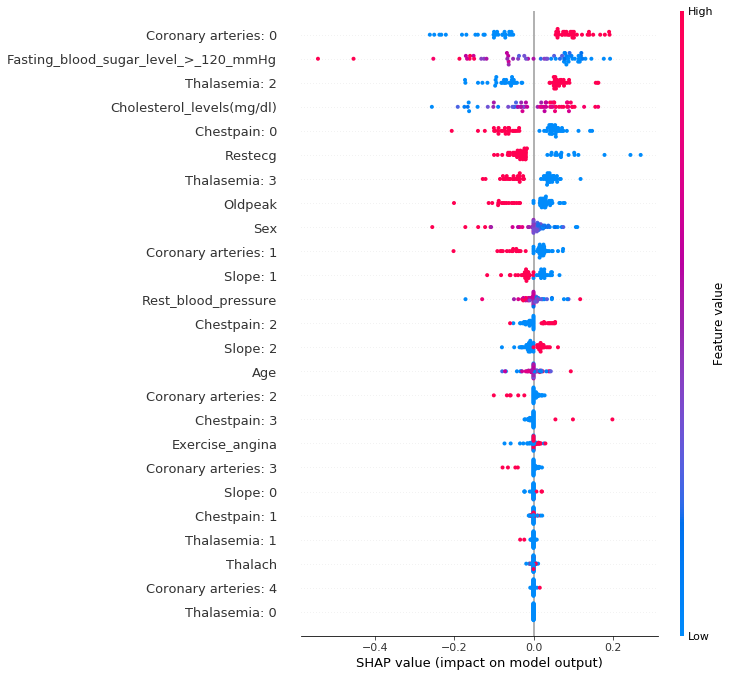

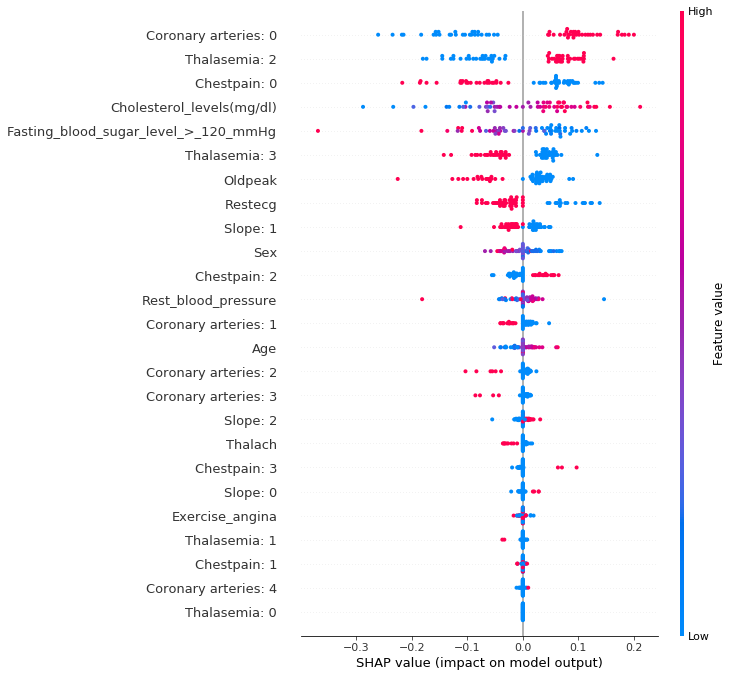

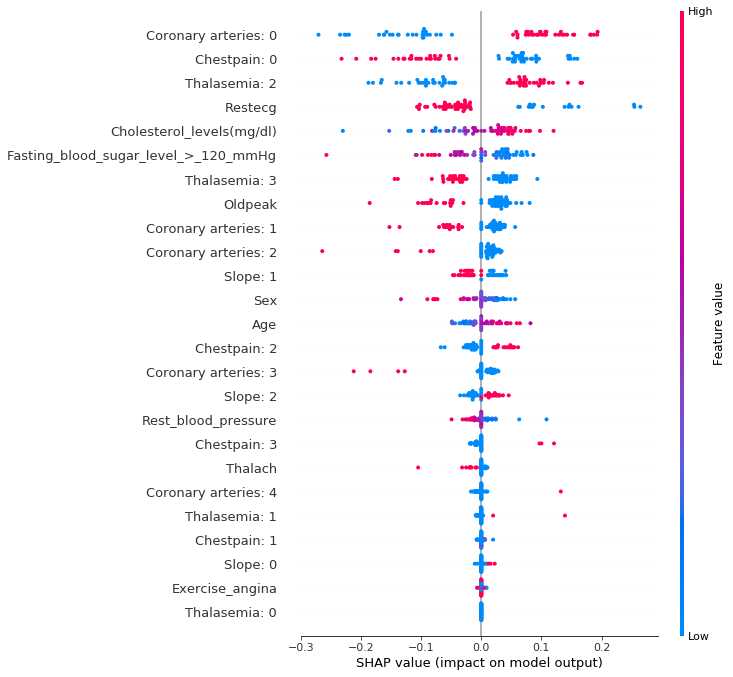

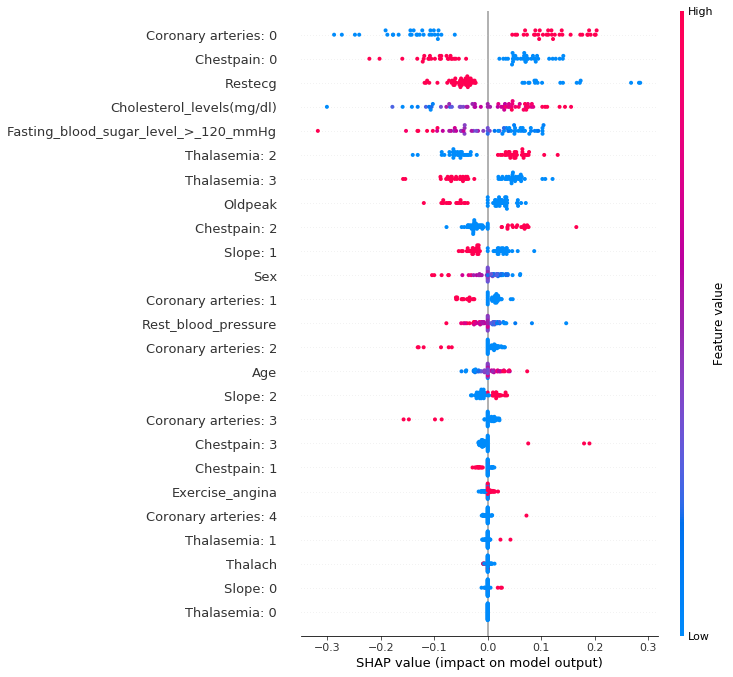

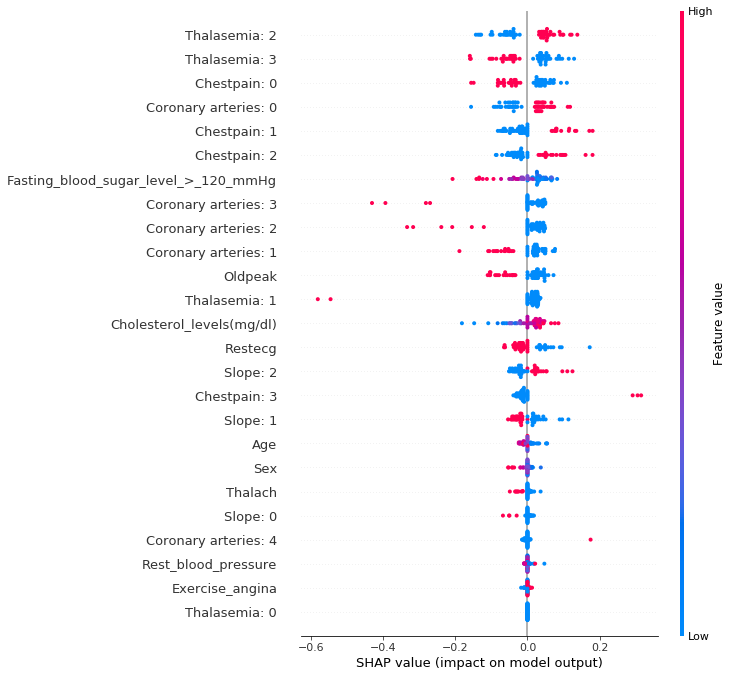

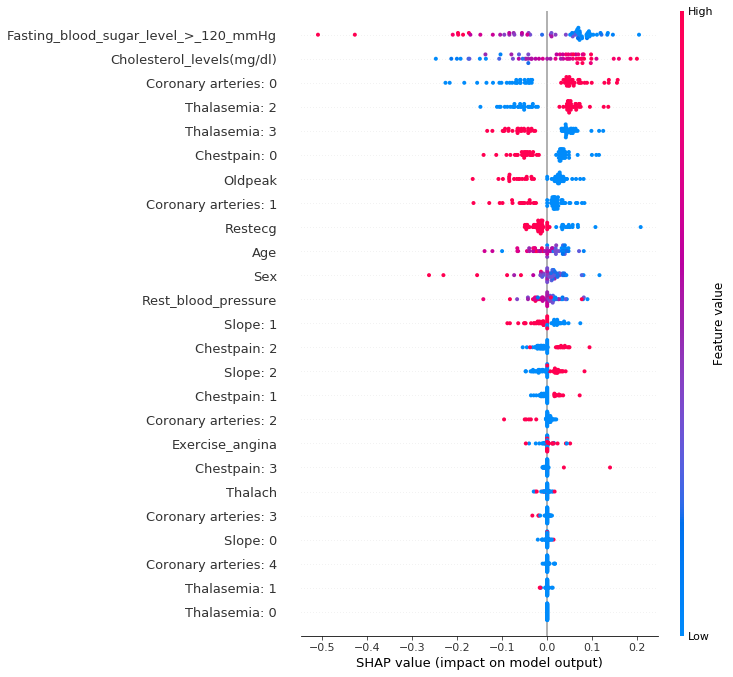

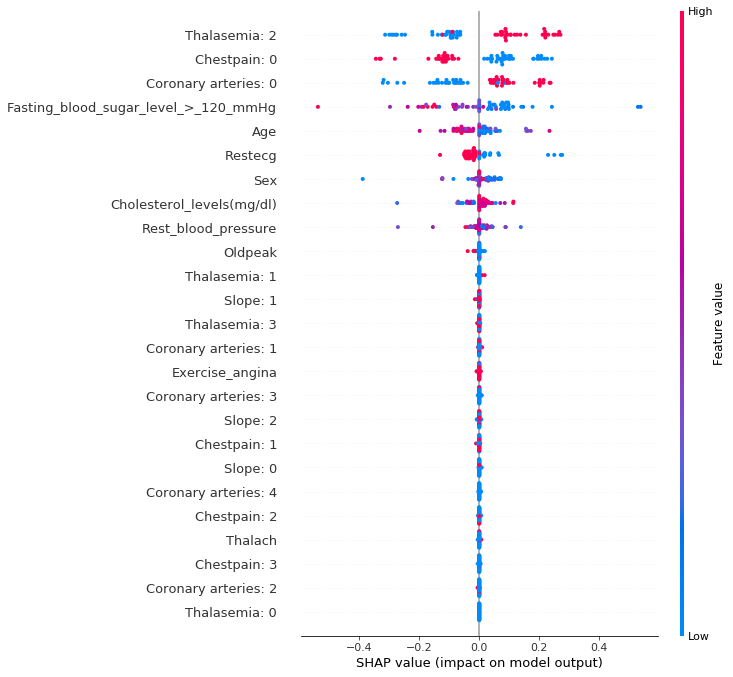

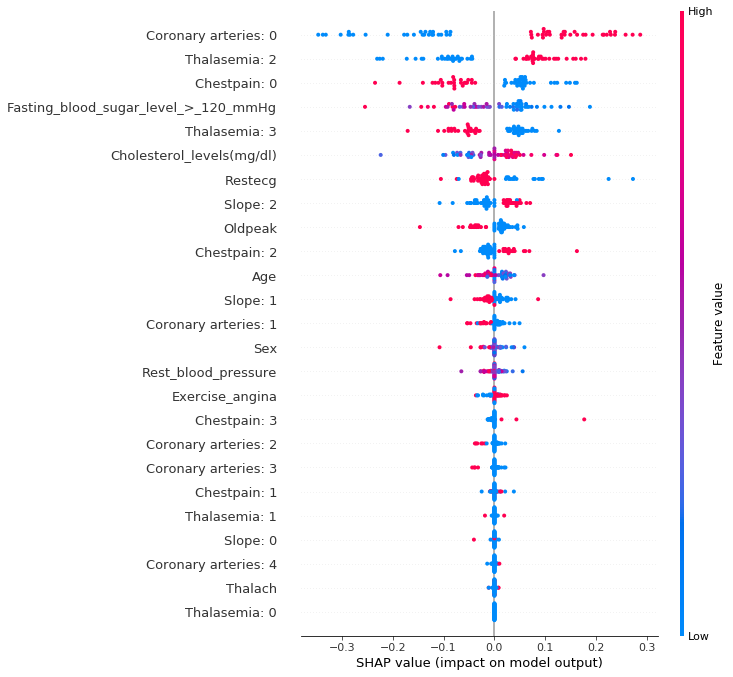

In [112]:
for model in results:
    shap.summary_plot(results[model]["shap_values"], X_test_preproc, max_display = 30, title = model)
    print("\n")

## SHAP value discussion

Looking at the SHAP summary plots for the different approaches reveals that with the exception of the naieve Bayes classifier and 9-KNN, the 0 coronary arteries visible during coronary angiogram fluoroscopy feature scores as the most impactfull feature. Second to this top-ranking phenomenon it also shows a rather large spread and separation among both classes in most cases. This observation might implicate that this feature is generally of big importance in determining heart disease.

### Age

From the plots we can observe that the age feature is not top ranked and in each occurence presents a smear of the data points with both the high and low feature values having tending to the center.

### Sex

Similar to the age feature the sex feature seems to create overlaps between both classes as well as not being spread out enough to really have a big impact.

### Chestpain: 0, 1, 2, 3

Chestpain 0 = ++

Chestpain 1 = -

Chestpain 2 = +

Chestpain 3 = -/+

### Rest Blood Pressure

Also a smear

### Cholesterol

Also a smear, yet rather spread out. Using upper and lower thresholds might be a good measure for some people? Also interaction effects -> pdp for 2 feature.

### Fasting Blood Sugar levels

Same as the cholesterol

### Rest electrocardiogram

Shows a clear separation between both classes with a somewhat broad spectrum

### Thalach

Over all the models the impact is practically absent.

### Exercised angina

Does not seem to have a huge impact on any of the models predictive capabilities

### Oldpeak

In most of the models there is a clear separation between the high and low values on the models predictive capabilities


### Slope

Slope 0 -> no impact

Slope 1 -> Some impact

Slope 2 -> Some impact

### Visible coronary arteries on fluoroscopy: 0, 1, 2, 3, 4

Coronary artery 0 -> shows a high impact and class separation on the model and classes respectively

Coronary artery 1, 2, 3 and 4  -> seems to show a decreasing effect on predictive capability

### Thalasemia 0, 1, 2

Thalasemia 0 -> on all model show zero impact on predictive power -> reason might be the low amount of times this value represented (Might justify the use of CV training of the models)

Thalasemia 1 -> On all modelsn except maybe Naieve Bayes migh have some impact ->  reason might be the low amount of times this value represented (Might justify the use of CV training of the models)

Thalasemia 2 -> Seems to be an important feature for most models

Thalasemia 3 -> Seems to be an important feature for most models (except in on were it does not have any impact at all)

## Redo with reduced features

In [117]:
X_train_reduced = X_train.drop(['Age', 'Sex', 'Exercise_angina', 'Thalach'], axis = 1)
X_test_reduced = X_test.drop(['Age', 'Sex', 'Exercise_angina', 'Thalach'], axis = 1)
X_train_scaled_reduced = X_train_scaled.drop(['Age', 'Sex', 'Exercise_angina', 'Thalach'], axis = 1)
X_test_scaled_reduced = X_test_scaled.drop(['Age', 'Sex', 'Exercise_angina', 'Thalach'], axis = 1)
X_train_preproc_reduced = X_train_preproc.drop(['Age', 'Sex', 'Exercise_angina', 'Thalach'], axis = 1)
X_test_preproc_reduced = X_test_preproc.drop(['Age', 'Sex', 'Exercise_angina', 'Thalach'], axis = 1)

In [146]:
for data_set, preproc in zip([[X_train_reduced, y_train, X_test_reduced, y_test], [X_train_scaled_reduced, y_train, X_test_scaled_reduced, y_test], [X_train_preproc_reduced, y_train, X_test_preproc_reduced, y_test]], ["Default", "StandardScaler",  "Preprocessing"]):
    
    print(preproc + "\n")
    
    for model in models:

        print(model[1])
        run_model(model[0], data_set[0], data_set[1], data_set[2], data_set[3])

Default

Linear_SVC
Prediction score on training data: 82.64
Prediction score on test data: 83.61
Confusion matrix:

[[20  3]
 [ 7 31]]
This model has a sensitivity of 0.82 and a specificity of 0.87
The Area Under the Curve (AUC) is 84.27


RBF_SVC
Prediction score on training data: 54.13
Prediction score on test data: 55.74
Confusion matrix:

[[ 0  0]
 [27 34]]
This model has a sensitivity of 0.56 and a specificity of nan
The Area Under the Curve (AUC) is nan


sigmoid_SVC
Prediction score on training data: 51.24
Prediction score on test data: 52.46
Confusion matrix:

[[ 1  3]
 [26 31]]
This model has a sensitivity of 0.54 and a specificity of 0.25
The Area Under the Curve (AUC) is 39.69


RidgeClassifier
Prediction score on training data: 81.4
Prediction score on test data: 81.97
Confusion matrix:

[[19  3]
 [ 8 31]]
This model has a sensitivity of 0.79 and a specificity of 0.86
The Area Under the Curve (AUC) is 82.93


LogisticRegression
Prediction score on training data: 83.88
Pred

# Conclusion